In [14]:
# LAYA on Fashion-MNIST (minimal demo)
# -----------------------------------
# This notebook:
#   1) builds an MLP backbone with exposed hidden states,
#   2) attaches a LAYA (Layer-wise Attention Aggregator) head,
#   3) trains on Fashion-MNIST,
#   4) extracts layer-wise attention weights (alphas),
#   5) visualizes global and class-wise attention profiles.

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LayerNormalization

from sklearn.metrics import accuracy_score, f1_score

sns.set_theme(context="notebook", style="whitegrid")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [15]:
# Global training configuration
SEED = 1337
EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE = 3e-4
VAL_SPLIT = 0.1
PATIENCE = 5

# Backbone configuration (matching the paper)
HIDDEN_SIZES = [512, 256, 128]
BACKBONE_USE_BIAS = True
LN_CENTER = True
LN_SCALE = True

NUM_CLASSES = 10  # Fashion-MNIST has 10 classes

def set_global_seed(seed: int):
    """Set all relevant random seeds for reproducibility."""
    import random as _random
    np.random.seed(seed)
    _random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    try:
        tf.config.experimental.enable_op_determinism()
    except Exception:
        pass

set_global_seed(SEED)

In [16]:
def build_backbone(input_dim: int, hidden_sizes: list, use_bias: bool = BACKBONE_USE_BIAS):
    """
    Build an MLP backbone with LayerNorm + GELU that exposes all hidden states.

    Args:
        input_dim: dimensionality of the flattened input.
        hidden_sizes: list of hidden widths per layer.
        use_bias: whether to use bias in Dense layers.

    Returns:
        inputs: Keras Input tensor.
        h_list: list of hidden tensors [h1, h2, ..., hL].
    """
    inputs = keras.Input(shape=(input_dim,), name="input")
    x = inputs
    h_list = []
    for i, hs in enumerate(hidden_sizes, start=1):
        x = layers.Dense(hs, use_bias=use_bias, name=f"dense_{i}")(x)
        x = LayerNormalization(center=LN_CENTER, scale=LN_SCALE, name=f"ln_{i}")(x)
        x = layers.Activation("gelu", name=f"gelu_{i}")(x)
        h_list.append(x)
    return inputs, h_list

In [17]:
from dataclasses import dataclass

@dataclass
class LAYAConfig:
    """Configuration for the LAYA head."""
    d_star: int = 96        # adapter dimension (best on Fashion-MNIST)
    tau: float = 1.5        # temperature for softmax over layers
    psi_type: str = "identity"  # {"identity", "mlp"}
    score_hidden: int = 192     # hidden width for scorer MLP


class LAYAHead(keras.Model):
    """
    LAYA: Layer-wise Attention Aggregator.

    Given hidden states [h1,...,hL], it computes:
        z_i = g_i(h_i)                  (adapters to R^{d*})
        u_i = ψ(z_i)                    (shared transform; MLP or identity)
        s   = MLP_score([u_1,...,u_L])  (depth-wise scores)
        α   = softmax(s / τ)            (attention over layers)
        h_agg = Σ_i α_i z_i
        logits = W h_agg + b
    It returns either:
        - class probabilities only, or
        - (class probabilities, alphas), for interpretability.
    """
    def __init__(self, L: int, num_classes: int, cfg: LAYAConfig, name="LAYAHead"):
        super().__init__(name=name)
        self.L = L
        self.num_classes = num_classes
        self.cfg = cfg

        # Adapters g_i: R^{d_i} -> R^{d*}
        self.adapters = [
            layers.Dense(cfg.d_star, use_bias=True, name=f"g{i+1}_proj")
            for i in range(L)
        ]

        # Shared ψ: either identity or a small MLP
        if cfg.psi_type == "identity":
            self.psi = keras.Sequential(
                [layers.Lambda(lambda z: z, name="psi_id")],
                name="psi"
            )
        else:
            self.psi = keras.Sequential(
                [
                    layers.Dense(cfg.d_star, activation="gelu", name="psi_mlp1"),
                    layers.Dense(cfg.d_star, activation="gelu", name="psi_mlp2"),
                ],
                name="psi"
            )

        # Scorer over concatenated u_i
        sh = cfg.score_hidden
        self.scorer = keras.Sequential(
            [
                layers.Dense(sh, activation="gelu", name="score_mlp1"),
                layers.Dense(L, activation=None, name="score_logits"),
            ],
            name="scorer"
        )

        # Final classifier W,b
        self.classifier = layers.Dense(num_classes, use_bias=True, name="clf")

        # Fixed temperature τ
        self.tau = tf.constant(cfg.tau, dtype=tf.float32)

    def call(self, h_list, training=None, return_alphas: bool = True):
        """
        Forward pass.

        Args:
            h_list: list of tensors [h1,...,hL] from the backbone.
            return_alphas: if True, also return attention weights α.

        Returns:
            probs: class probabilities, shape (B, num_classes).
            (optionally) alphas: attention weights over layers, shape (B, L).
        """
        # z_i = g_i(h_i)
        zs = [self.adapters[i](h_list[i]) for i in range(self.L)]
        # u_i = ψ(z_i)
        us = [self.psi(z) for z in zs]
        # Concatenate all u_i
        u_cat = layers.Concatenate(name="concat_u")(us)  # (B, L * d_star)
        # Scores over layers
        scores = self.scorer(u_cat)                      # (B, L)
        # Attention over layers
        alphas = tf.nn.softmax(scores / self.tau, axis=-1)  # (B, L)
        # Aggregate z_i with α_i
        z_stack = tf.stack(zs, axis=2)                      # (B, d_star, L)
        h_agg = tf.reduce_sum(
            z_stack * tf.expand_dims(alphas, axis=1),
            axis=2
        )                                                   # (B, d_star)
        # Class logits and probabilities
        logits = self.classifier(h_agg)                     # (B, num_classes)
        probs = tf.nn.softmax(logits, axis=-1)
        if return_alphas:
            return probs, alphas
        return probs

In [18]:
def build_laya_classifier(input_dim: int,
                          hidden_sizes: list,
                          num_classes: int,
                          cfg: LAYAConfig):
    """
    Build a Keras Model for classification with LAYA as the output head.
    This version returns probabilities only (no alphas), suitable for training.
    """
    inputs, h_list = build_backbone(input_dim, hidden_sizes, use_bias=BACKBONE_USE_BIAS)
    laya_head = LAYAHead(L=len(h_list), num_classes=num_classes, cfg=cfg)
    probs = laya_head(h_list, return_alphas=False)
    model = keras.Model(inputs=inputs, outputs=probs, name="MLP_LAYA")
    return model


def compile_model(model: keras.Model, lr: float = LEARNING_RATE):
    """
    Compile the model with a standard sparse categorical crossentropy loss.
    """
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [19]:
# Load Fashion-MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize to [0,1] and flatten (28x28 -> 784)
x_train = (x_train.astype("float32") / 255.0).reshape(len(x_train), -1)
x_test  = (x_test.astype("float32")  / 255.0).reshape(len(x_test),  -1)

input_dim = x_train.shape[1]
print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)

Train: (60000, 784) (60000,)
Test : (10000, 784) (10000,)


In [20]:
# Best LAYA configuration found in the paper for Fashion-MNIST
best_cfg = LAYAConfig(
    d_star=96,
    tau=1.5,
    psi_type="identity",
    score_hidden=192,
)
print("Using LAYA config:", best_cfg)

set_global_seed(SEED)
laya_model = build_laya_classifier(
    input_dim=input_dim,
    hidden_sizes=HIDDEN_SIZES,
    num_classes=NUM_CLASSES,
    cfg=best_cfg,
)
compile_model(laya_model)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=PATIENCE,
        restore_best_weights=True
    )
]

history = laya_model.fit(
    x_train, y_train,
    validation_split=VAL_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=callbacks
)

# Evaluate on test set
test_loss, test_acc = laya_model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest accuracy (LAYA, single run): {test_acc:.4f}")

Using LAYA config: LAYAConfig(d_star=96, tau=1.5, psi_type='identity', score_hidden=192)
Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.7856 - loss: 0.6104 - val_accuracy: 0.8617 - val_loss: 0.3769
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8809 - loss: 0.3262 - val_accuracy: 0.8713 - val_loss: 0.3511
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8978 - loss: 0.2791 - val_accuracy: 0.8753 - val_loss: 0.3444
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9079 - loss: 0.2500 - val_accuracy: 0.8777 - val_loss: 0.3459
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9170 - loss: 0.2238 - val_accuracy: 0.8770 - val_loss: 0.3548
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9263 - loss: 0.2001 - val_accuracy: 0.8782 - val_loss: 0.3576
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9333 - loss: 0.1850 - val_accuracy: 0.8697 - val_loss: 0.3843
Epoch 8

In [21]:
# Compute predictions and macro-F1 for completeness
y_prob = laya_model.predict(x_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Macro-F1: {f1_macro:.4f}")

Test Accuracy: 0.8842
Test Macro-F1: 0.8835


In [22]:
def build_laya_with_alphas(input_dim: int,
                           hidden_sizes: list,
                           num_classes: int,
                           cfg: LAYAConfig):
    """
    Build a Keras Model that outputs both class probabilities and alphas.
    This has the same architecture as the classifier model, but returns
    (probs, alphas) instead of probs only.
    """
    inputs, h_list = build_backbone(input_dim, hidden_sizes, use_bias=BACKBONE_USE_BIAS)
    laya_head = LAYAHead(L=len(h_list), num_classes=num_classes, cfg=cfg)
    probs, alphas = laya_head(h_list, return_alphas=True)
    model = keras.Model(inputs=inputs, outputs=[probs, alphas], name="MLP_LAYA_with_alphas")
    return model


def rewrap_laya_with_alphas(single_output_model: keras.Model,
                            input_dim: int,
                            hidden_sizes: list,
                            num_classes: int,
                            cfg: LAYAConfig):
    """
    Create a dual-output LAYA model and copy weights from a trained
    single-output LAYA classifier.
    """
    dual_model = build_laya_with_alphas(
        input_dim=input_dim,
        hidden_sizes=hidden_sizes,
        num_classes=num_classes,
        cfg=cfg
    )
    dual_model.set_weights(single_output_model.get_weights())
    return dual_model

probe_model = rewrap_laya_with_alphas(
    single_output_model=laya_model,
    input_dim=input_dim,
    hidden_sizes=HIDDEN_SIZES,
    num_classes=NUM_CLASSES,
    cfg=best_cfg
)

print("Probe model with alphas is ready.")

Probe model with alphas is ready.


In [23]:
def predict_probs_and_alphas(model, x, batch_size=512):
    """
    Run the dual-output LAYA model on x and return (probs, alphas).
    """
    probs_list, alphas_list = [], []
    N = x.shape[0]
    for i in range(0, N, batch_size):
        xb = x[i:i+batch_size]
        y = model.predict(xb, verbose=0)
        if isinstance(y, (list, tuple)) and len(y) == 2:
            p, a = y
        else:
            raise ValueError("Model must output [probs, alphas].")
        probs_list.append(p)
        alphas_list.append(a)
    return np.concatenate(probs_list, axis=0), np.concatenate(alphas_list, axis=0)

probs_full, alphas_full = predict_probs_and_alphas(probe_model, x_test, batch_size=512)
y_pred_full = np.argmax(probs_full, axis=1)

print("Alphas shape:", alphas_full.shape)  # (N_test, L)

Alphas shape: (10000, 3)


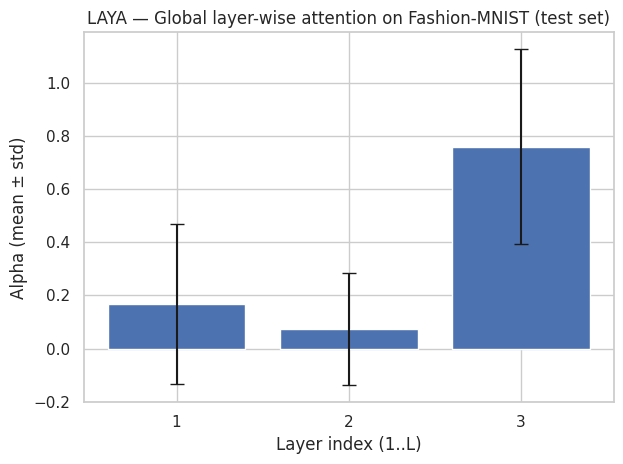

In [24]:
def summarize_alphas(alphas: np.ndarray):
    """
    Compute mean and std per layer index over all samples.

    Args:
        alphas: array of shape [N, L].

    Returns:
        mean: (L,) array.
        std:  (L,) array.
    """
    return np.mean(alphas, axis=0), np.std(alphas, axis=0)

alpha_mean, alpha_std = summarize_alphas(alphas_full)
L = alphas_full.shape[1]
layers_idx = np.arange(1, L + 1)  # use 1..L for plotting

plt.figure()
plt.bar(layers_idx, alpha_mean, yerr=alpha_std, capsize=5)
plt.xlabel("Layer index (1..L)")
plt.ylabel("Alpha (mean ± std)")
plt.title("LAYA — Global layer-wise attention on Fashion-MNIST (test set)")
plt.xticks(layers_idx)
plt.tight_layout()
plt.show()

In [25]:
# Masks for correct / incorrect predictions
correct_mask = (y_pred_full == y_test)
incorrect_mask = ~correct_mask

print(f"Test size: {len(y_test)}")
print(f"Correct predictions  : {int(correct_mask.sum())}")
print(f"Incorrect predictions: {int(incorrect_mask.sum())}")


def compute_classwise_profiles(alphas: np.ndarray,
                               y_true: np.ndarray,
                               mask: np.ndarray | None,
                               num_classes: int):
    """
    Compute class-wise attention profiles (mean ± std) per class and per layer.

    Returns a DataFrame with columns:
        class, layer, alpha_mean, alpha_std, n
    """
    if mask is None:
        mask = np.ones_like(y_true, dtype=bool)

    rows = []
    L_local = alphas.shape[1]
    for c in range(num_classes):
        idx = (y_true == c) & mask
        if idx.sum() == 0:
            # No samples for this class under the mask
            for l in range(L_local):
                rows.append((c, l + 1, np.nan, np.nan, 0))
            continue
        A = alphas[idx]  # [n_c, L]
        m = A.mean(axis=0)
        s = A.std(axis=0)
        for l in range(L_local):
            rows.append((c, l + 1, float(m[l]), float(s[l]), int(A.shape[0])))
    df = pd.DataFrame(rows, columns=["class", "layer", "alpha_mean", "alpha_std", "n"])
    return df


profiles_all = compute_classwise_profiles(alphas_full, y_test, None, NUM_CLASSES)
profiles_correct = compute_classwise_profiles(alphas_full, y_test, correct_mask, NUM_CLASSES)
profiles_incorrect = compute_classwise_profiles(alphas_full, y_test, incorrect_mask, NUM_CLASSES)

profiles_all.head()

Test size: 10000
Correct predictions  : 8842
Incorrect predictions: 1158


,class,layer,alpha_mean,alpha_std,n
0,0,1,0.221382,0.171158,1000
1,0,2,0.528135,0.322823,1000
2,0,3,0.250482,0.300106,1000
3,1,1,0.017224,0.075450,1000
4,1,2,0.002482,0.016533,1000


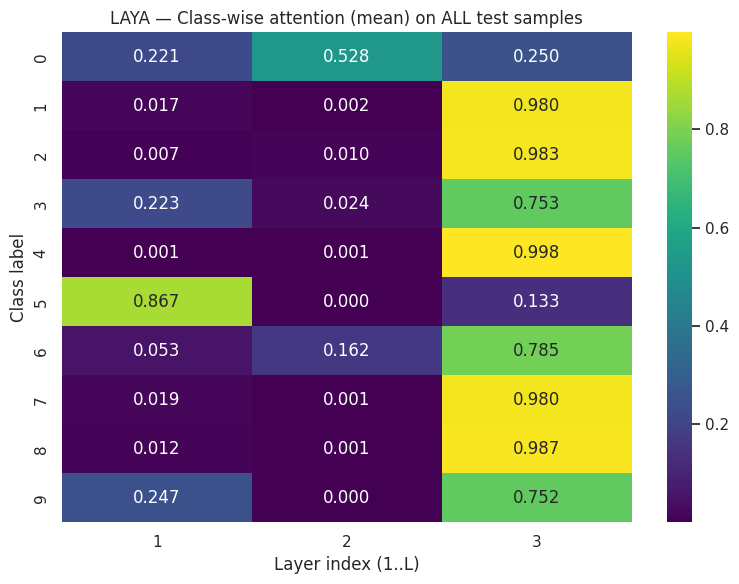

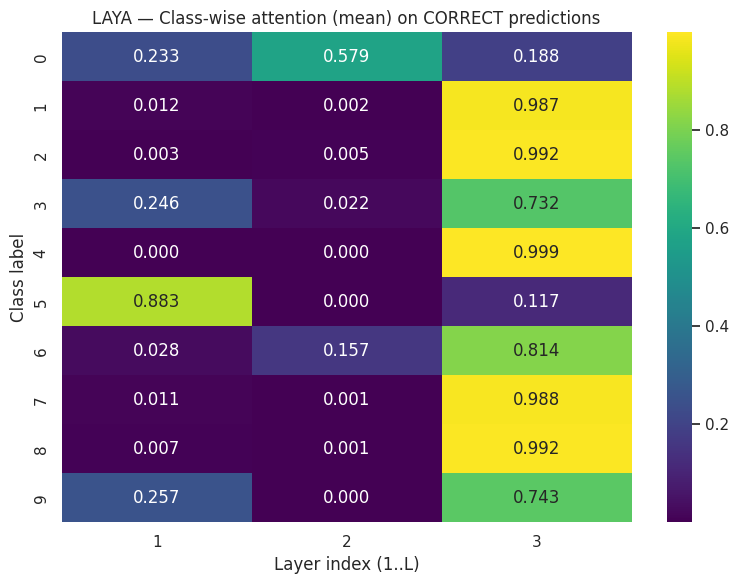

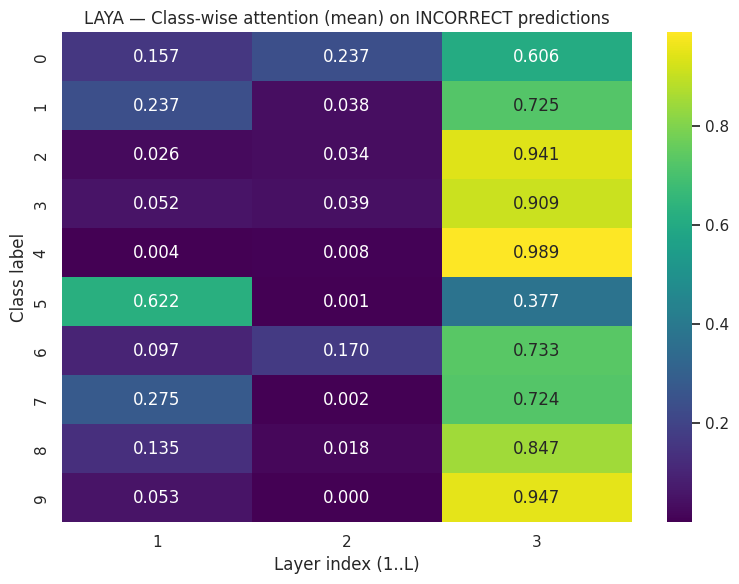

In [26]:
def plot_classwise_heatmap(profiles_df: pd.DataFrame,
                           title: str):
    """
    Plot class x layer heatmap of mean alpha values.
    """
    heat_df = profiles_df.pivot(index="class", columns="layer", values="alpha_mean")
    plt.figure(figsize=(8, 6))
    sns.heatmap(heat_df, annot=True, fmt=".3f", cmap="viridis")
    plt.title(title)
    plt.ylabel("Class label")
    plt.xlabel("Layer index (1..L)")
    plt.tight_layout()
    plt.show()


plot_classwise_heatmap(
    profiles_all,
    "LAYA — Class-wise attention (mean) on ALL test samples"
)

plot_classwise_heatmap(
    profiles_correct,
    "LAYA — Class-wise attention (mean) on CORRECT predictions"
)

plot_classwise_heatmap(
    profiles_incorrect,
    "LAYA — Class-wise attention (mean) on INCORRECT predictions"
)